In [1]:
from datetime import datetime
import pandas as pd

data_path = "data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"

df = pd.read_csv(data_path)
df["start_timestamp"] = df["end_timestamp"] - df["duration"]
df = df.sort_values(by="start_timestamp", ascending=True)
df["start_timestamp"] = pd.to_datetime(df["start_timestamp"], unit="s", origin=datetime.now())
df = df.drop("app", axis=1).drop("end_timestamp", axis=1).drop("duration", axis=1)
df.head()

,func,start_timestamp
0,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,2025-03-20 17:58:33.001490831
1,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,2025-03-20 17:58:33.003859997
2,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,2025-03-20 17:58:33.005477905
3,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,2025-03-20 17:58:33.016541004
4,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,2025-03-20 17:58:33.016824007


In [ ]:
from simulator import ServerlessSimulator, Distribution

# Taken from measurements for simulator
warm_dist = Distribution([0.000017, 0.000015], [0.021617, 0.010093], [0.000007, 0.000005])
cold_dist = Distribution([1.121333, 0.629269], [0.220730, 0.045443], [0.000013, 0.000009])

sim = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=10,
                          predictor_interval=10,
                          predictor_history_interval=100000,
                          granularity=1
                        )

logs = sim.run(with_model=True)

sim = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=10,
                          predictor_interval=10,
                          predictor_history_interval=10000000,
                          granularity=1
                        )

logs = sim.run(with_model=True)

100%|██████████| 100/100 [00:00<00:00, 1323.20it/s]


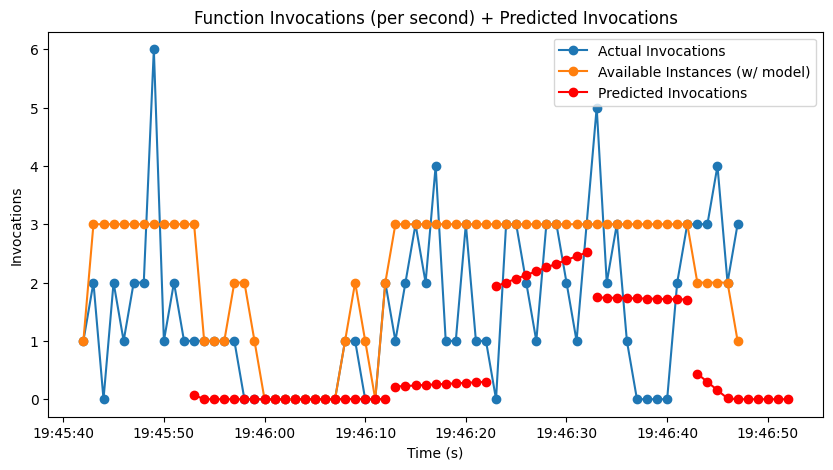

In [3]:
import matplotlib.pyplot as plt

f = sim._functions[df["func"].mode()[0]]

plt.figure(figsize=(10, 5))
plt.title("Function Invocations (per second) + Predicted Invocations")
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.plot(f.history['ds'], f.history['y'], '-o', label="Actual Invocations")

plt.plot(f.history['ds'], f.history['available_containers'], '-o', label="Available Instances (w/ model)")
# plt.plot(remaining_instances_no['ds'], remaining_instances_no['num'], '-o', label="Available Instances (w/o model)")

for pred in f.predictions:
    plt.plot(pred['ds'], list(map(lambda x: 0 if x < 0 else x, pred['yhat'])), '-o', color="red", label="Predicted Invocations")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Number of cold starts: 7
Number of warm starts: 93


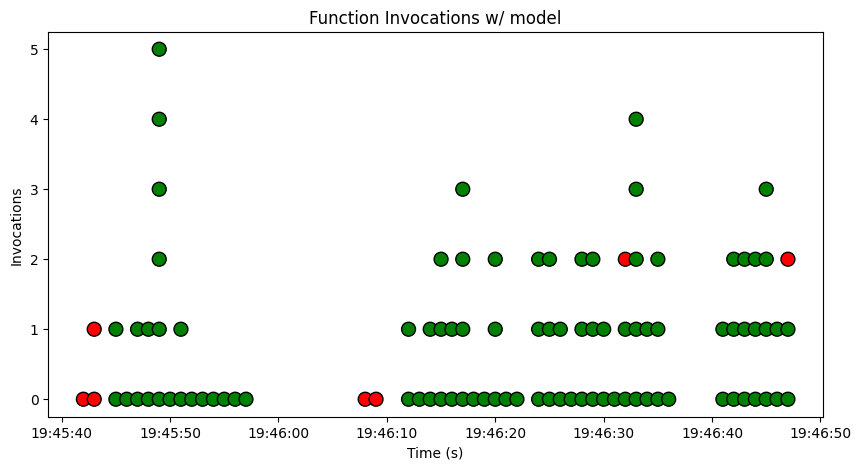

In [ ]:
invoked_floor = pd.DataFrame(logs)
invoked_floor['ds'] = invoked_floor['ds'].dt.floor('s')
invoked_floor['y_jitter'] = invoked_floor.groupby('ds').cumcount()
invoked_floor['color'] = invoked_floor['is_warm_start'].map({False: 'red', True: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor['ds'], invoked_floor['y_jitter'], c=invoked_floor['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/ model')

In [11]:
print("Number of cold starts: " + str(len(list(filter(lambda x: not x, logs['is_warm_start'])))))
print("Number of warm starts: " + str(len(list(filter(lambda x: x, logs['is_warm_start'])))))

Number of cold starts: 7
Number of warm starts: 93
